# Survival Analysis for RUL Prediction

Survival Models: 

- Regular Cox model (linear)

- Cox model with neural netowrk (nonlinear)

Tasks:
- Visual Exploration and Statistics of Data

- RUL Prediction (based on Failure-free Probability) via Survival Models

- Variable Imporatance Analysis based on Linear Cox Model

Candidate: jianfei.zhang@live.ca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
from sklearn.model_selection import train_test_split
from pycox.models import MTLR, CoxPH
from pysurvival.models import semi_parametric, survival_forest
from lifelines import CoxPHFitter, KaplanMeierFitter
from pysurvival.utils.display import correlation_matrix
import torch
import torchtuples as tt
from scipy.integrate import trapz

In [2]:
ID = 'ComponentID'
x_binary = ['ComponentType','Site']
x_categorical = 'Build'
x_numerical = ['AverageTirePressure', 'AveragePayload', 'TimeEnd']
x = x_binary + [x_categorical] + x_numerical

Failure = 'HardFailure'
Censored = 'HighHourChangeout'
RUL = 'RUL'

# load data
xls = pd.ExcelFile('RUL.xlsx')
d_train, d_test, d_pred = pd.read_excel(xls, 'Training_Data'), pd.read_excel(xls, 'Test_Data'), pd.read_excel(xls, 'Your_RUL_Predictions')

## Statistics

- Censoring rate

- Checking for null values

In [3]:
print('Censoring rate is %.2f%%' % (100*d_train[Censored].sum()/400))

Null_train, Null_test = sum(d_train[x].isnull().sum()), sum(d_test[x].isnull().sum())
print("{} null values in training data\n{} null values in test data".format(Null_train, Null_test)) #0 null values

Censoring rate is 61.75%
0 null values in training data
0 null values in test data


## Visual Exploration (see figures below)

- Three numerial variables have very few outliers and seem to follow normal distributions

- Three categorical variables follow uniform distributions

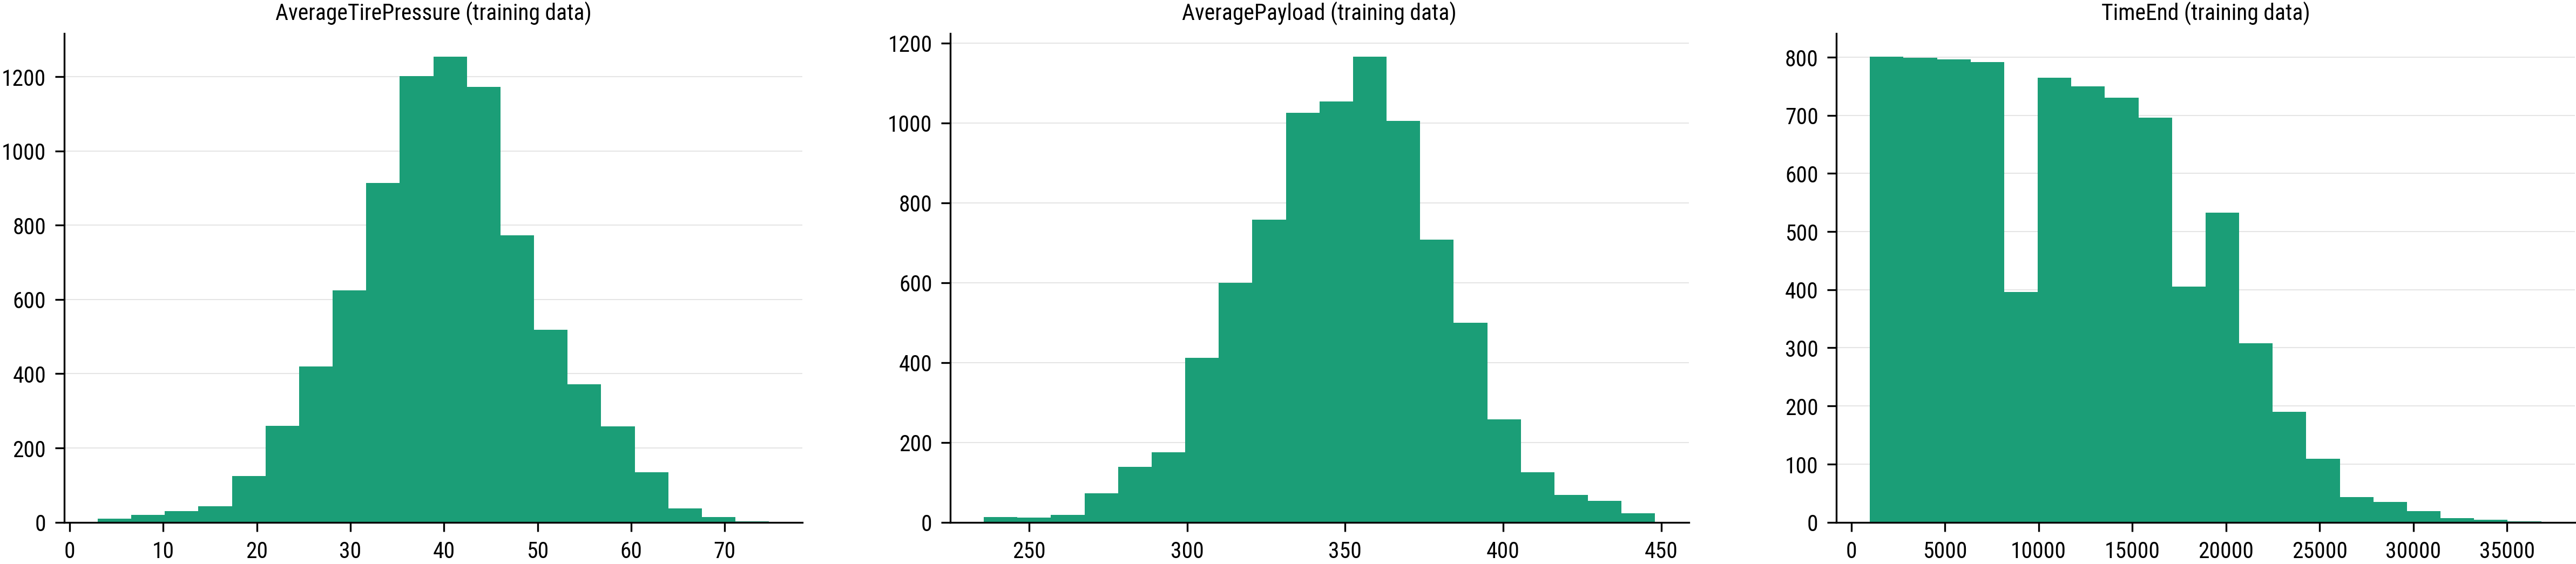

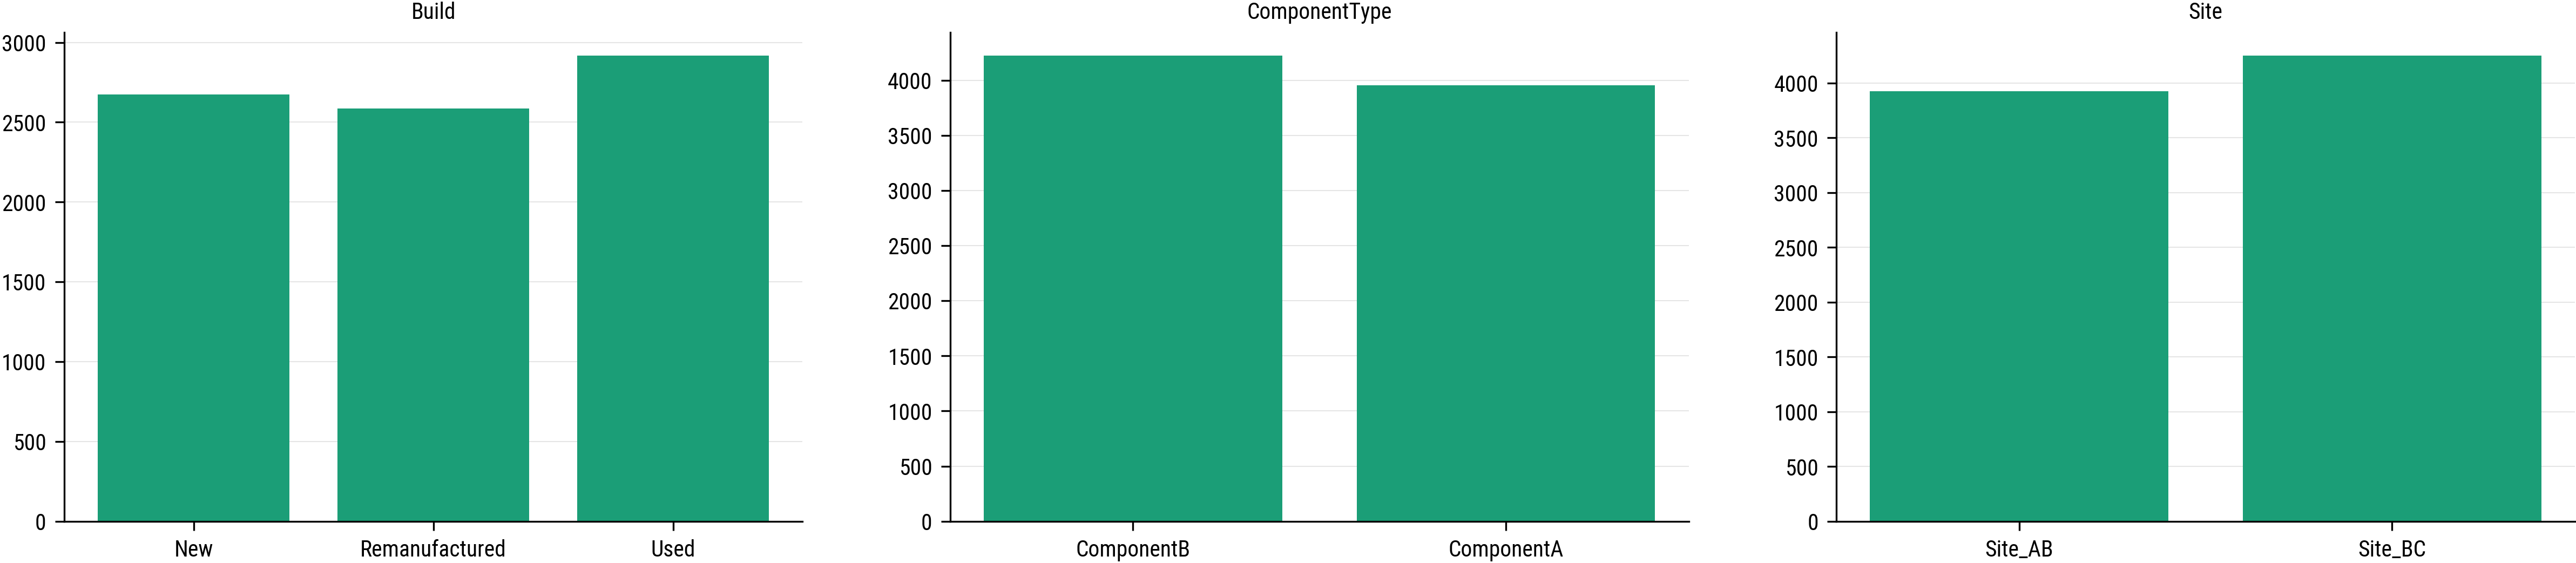

In [4]:
fig, ax  = plt.subplots(1, len(x_numerical),  figsize=(20, 4))

for i in range(len(x_numerical)):
    x = d_train[x_numerical[i]].values
    plt.subplot(1,len(x_numerical),i+1)
    plt.hist(x, bins=20)
    plt.title( '{} (training data)'.format(x_numerical[i]))
plt.show()

variables = [x_categorical]+x_binary
fig, ax  = plt.subplots(1, len(variables),  figsize=(20, 4))

for i in range(len(variables)):

    x = d_train[variables[i]].values
    plt.subplot(1,len(variables),i+1)
    
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())
    plt.bar(category, counts)

    plt.title( '{}'.format(variables[i]) )
plt.show()

## Data Pre-processing

In [5]:
# get the currently known maximum working hours of every component, also the event indicator that tells us it is a failure or changeout
def get_RUL(df):
    df[RUL] = df['TimeEnd'].max() - df['TimeEnd']
    return df

def get_Failure(df):
    df[Failure] = df[Failure].max()
    df[Censored] = df[Censored].max()
    return df

# to generate dummies for categorical variables
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(feature_to_encode, 1)
    return res, list(dummies.columns)

# encode the binary variables, to be 0 and 1
def binary_to_numerical(df,cols):
    for col in cols:
        df[col] = df[col].replace(df[col].unique(), [0,1])
    return df

# creat the RUL and Failure columns 
d_train = d_train.groupby([ID]).apply(get_Failure)
d_train = d_train.groupby([ID]).apply(get_RUL)
d_test = d_test.groupby([ID]).apply(get_RUL)

# remove the last row for each component
d_train = d_train.groupby(ID, as_index=False).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

# for test data, only use the last observation of each component to make a forecast
d_test = d_test.groupby([ID]).tail(1).reset_index(drop=True)

# merge training and test data
d = d_train.append(d_test)

# need to creat dummy variates associated with Build column that is categorical (not binary)
d, dummies = encode_and_bind(d, x_categorical)

# binary to numerical, ComponentA=0, ComponentB = 1, Site_AB=0, Site_BC=1
d = binary_to_numerical(d, ['ComponentType','Site'])

# remove two useless columns: HighHourChangeout and TimeStart
d = d.drop([Censored,'TimeStart'],1)

# did not change the components in training and test data, only preprocessed the variables for them meantime
df_train, df_test = d.loc[d[ID] <= 400], d.loc[d[ID] > 400]

df_train, df_test, df_pred = df_train.set_index(ID), df_test.set_index(ID), d_pred.set_index(ID)

In [6]:
df_train

,Build_New,Build_Remanufactured,Build_Used,ComponentType,Site,AverageTirePressure,AveragePayload,TimeEnd,HardFailure,RUL
ComponentID,,,,,,,,,,
1,1,0,0,0,0,40.783718,364.180358,999.0,1,26535.00000
1,1,0,0,0,0,44.372962,377.204568,1999.0,1,25535.00000
1,1,0,0,0,0,37.727584,372.054902,2999.0,1,24535.00000
1,1,0,0,0,0,46.846078,371.288781,3999.0,1,23535.00000
1,1,0,0,0,0,37.643642,373.507315,4999.0,1,22535.00000
...,...,...,...,...,...,...,...,...,...,...
400,0,0,1,0,0,51.405389,361.584026,14999.0,0,4893.89029
400,0,0,1,0,0,54.283232,370.463876,15999.0,0,3893.89029
400,0,0,1,0,0,56.025265,369.777628,16999.0,0,2893.89029


In [7]:
df_test

,Build_New,Build_Remanufactured,Build_Used,ComponentType,Site,AverageTirePressure,AveragePayload,TimeEnd,HardFailure,RUL
ComponentID,,,,,,,,,,
401,0,0,1,1,1,40.068781,306.779456,14999.0,0,0.0
402,1,0,0,0,1,48.207799,321.489396,3999.0,0,0.0
403,0,1,0,1,0,37.117465,341.172158,24999.0,0,0.0
404,1,0,0,0,0,30.636441,338.787427,21999.0,0,0.0
405,1,0,0,1,0,48.663344,329.041721,12999.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
796,0,0,1,0,0,34.775807,368.230240,5999.0,0,0.0
797,0,1,0,0,0,34.120139,342.185493,17999.0,0,0.0
798,1,0,0,0,0,31.913633,379.385402,16999.0,0,0.0


In [8]:
# will fill out this dataframe
df_pred

,RUL
ComponentID,
401,NaN
402,NaN
403,NaN
404,NaN
405,NaN
...,...
796,NaN
797,NaN
798,NaN


## Compute and visualize the correlation between the features

- (Figure 1 below) Display the occurrences of failure and censorship 

- (Figure 2 below) Display the distribution of the time output variable for both situations (RUL or censoring)

- (Figure 3 below) The correlation between variables, there aren't any alarming correlations (dark green)

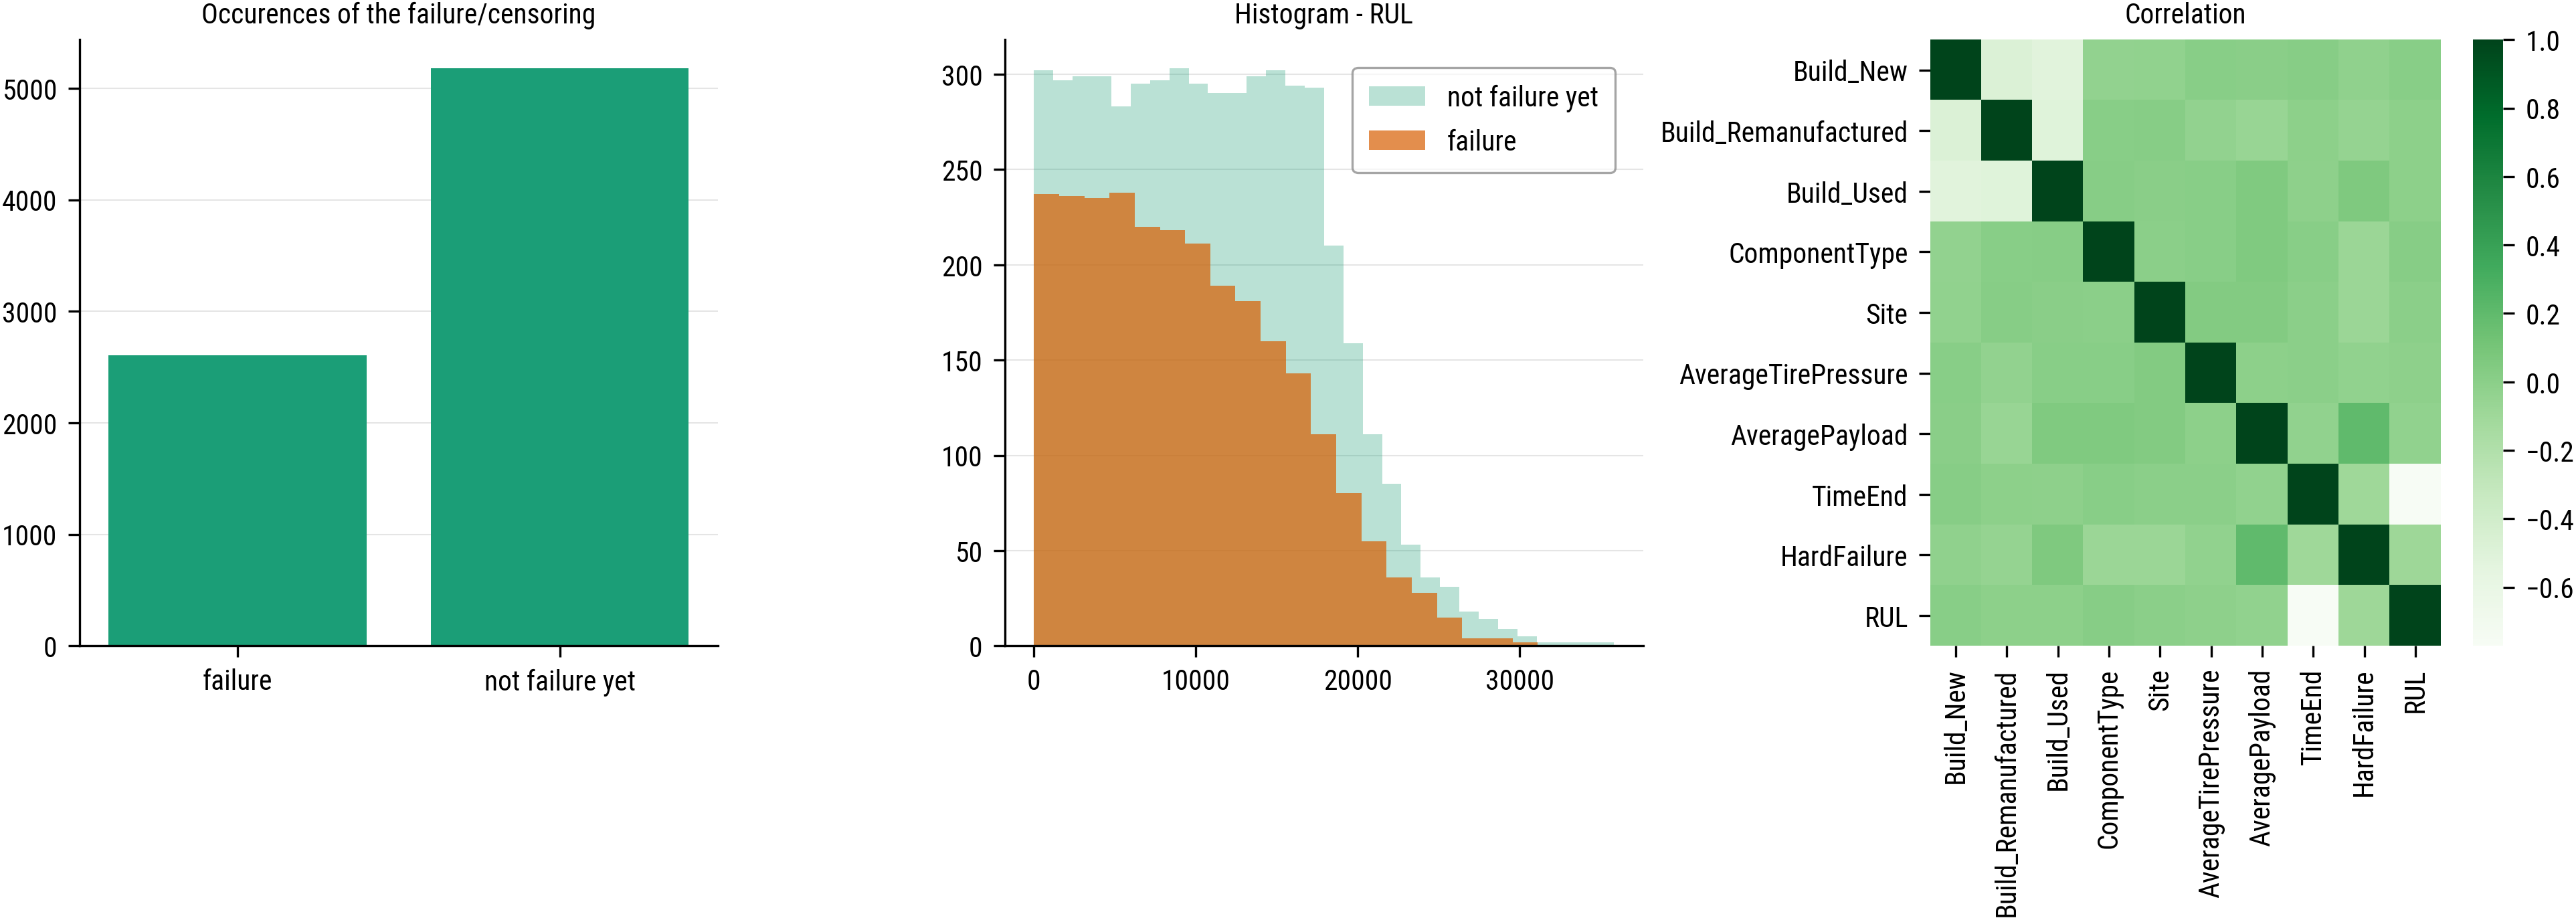

In [9]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,  figsize=(16, 4))
plt.subplots_adjust(wspace=.45, hspace=0)
# Counting the number of occurrences for each category 
data = Counter(df_train[Failure].replace({0:'not failure yet', 1:'failure'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Occurences of the failure/censoring')

# Showing the histogram of the survival times for the censoring
time_0 = df_train.loc[df_train[Failure] == 0, RUL]
ax2.hist(time_0, bins=30, alpha=0.3, label = 'not failure yet')

# Showing the histogram of the survival times for the events
time_1 = df_train.loc[df_train[Failure] == 1, RUL]
ax2.hist(time_1, bins=20, alpha=0.7, label = 'failure')
ax2.set_title('Histogram - RUL')
ax2.legend()

sns.heatmap(df_train.corr(), xticklabels=df_train.columns, yticklabels=df_train.columns, cmap="Greens", ax = ax3)
ax3.set_title('Correlation')

plt.show()

## Regular Cox model prediction

- The survival curve (failure-free probability) for 400 test components

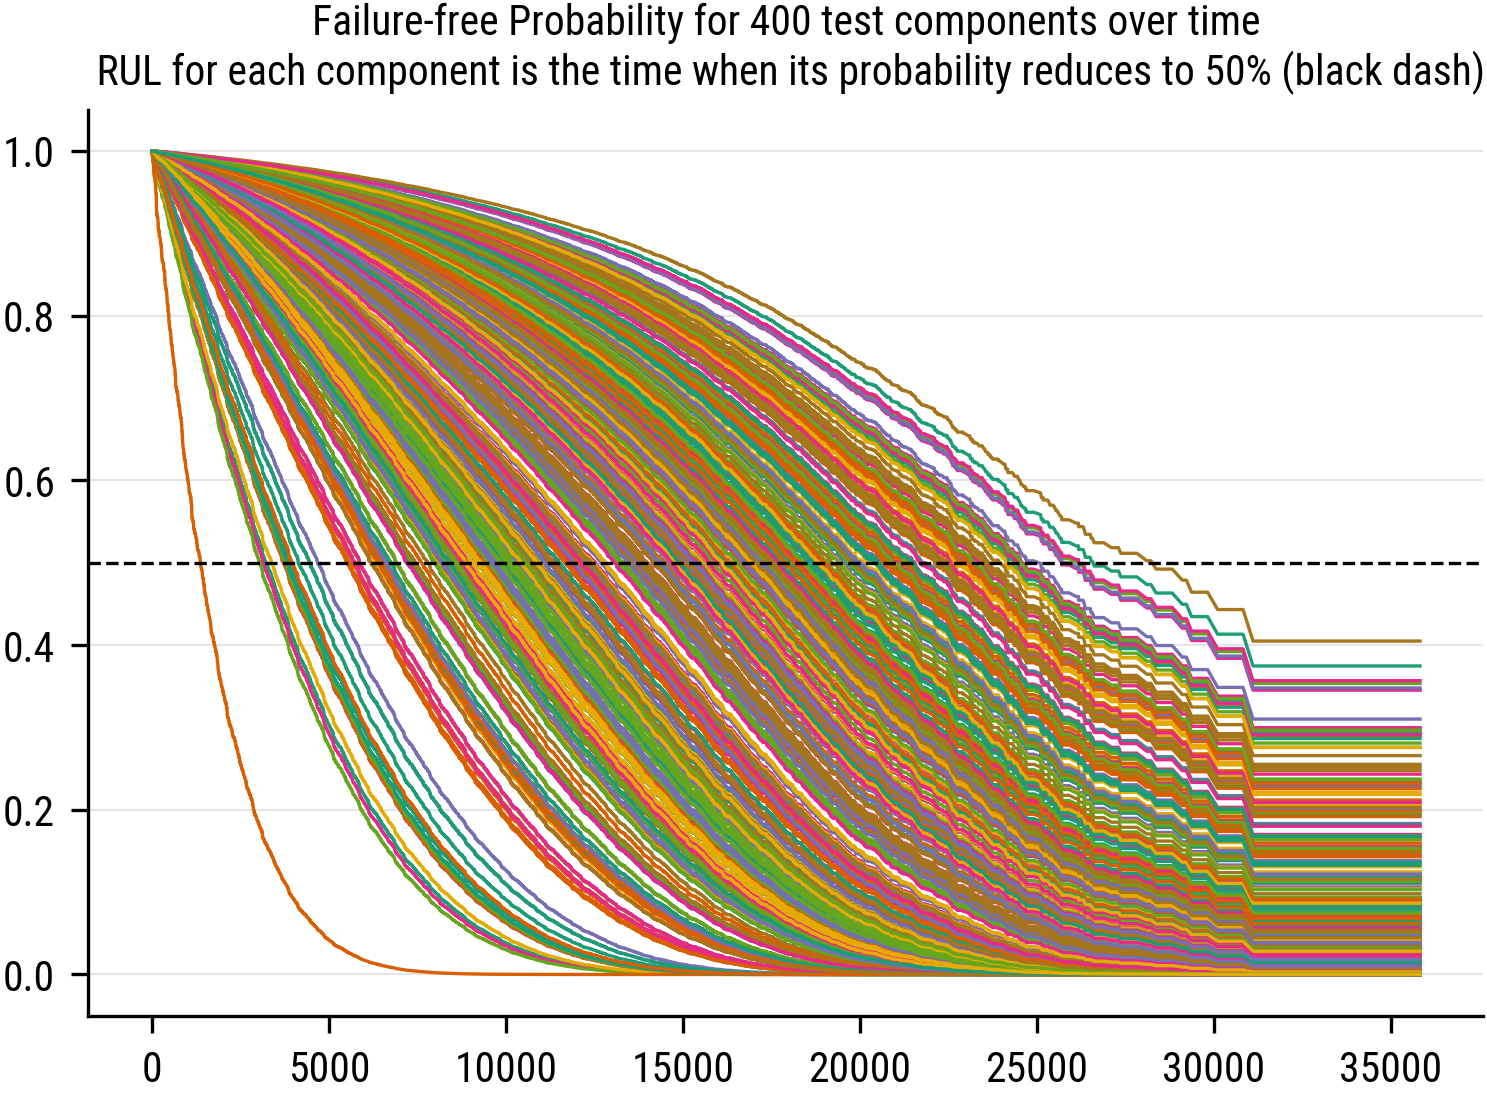

In [10]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_train, duration_col=RUL, event_col=Failure)

# show the probability curves for 400 test components
pred = cph.predict_survival_function(df_test)
plt.plot(pred)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title('Failure-free Probability for 400 test components over time\n RUL for each component is the time when its probability reduces to 50% (black dash)')
plt.show()

In [11]:
# output RUL
df_pred[RUL] = cph.predict_median(df_test)

df_pred

,RUL
ComponentID,
401,16841.0
402,23179.0
403,8333.0
404,8817.0
405,16733.0
...,...
796,15738.0
797,10575.0
798,9286.0


## Cox + Neural Network

In [13]:
def prepare_data(df_train, df_validation, df_test):
    # standardize the numerical variables
    numerical = [([col], StandardScaler()) for col in x_numerical]
    # leave the binary variables as they are
    binary = [(col, None) for col in dummies + x_binary]
    x_mapper = DataFrameMapper(numerical + binary)
    x_train = x_mapper.fit_transform(df_train).astype('float32')
    x_validation = x_mapper.transform(df_validation).astype('float32')
    x_test = x_mapper.transform(df_test).astype('float32')
    
    get_target = lambda df: (df[RUL].values, df[Failure].values)
    y_train = get_target(df_train)
    y_validation = get_target(df_validation)
    
    validation = (x_validation, y_validation)
    return x_train, y_train, validation, x_test


def train(x_train, y_train, validation, x_test):
    net = tt.practical.MLPVanilla(in_features = x_train.shape[1], 
                                  num_nodes = [30, 30], 
                                  out_features = 1, 
                                  batch_norm = True, 
                                  dropout = 0.1,
                                  output_bias = False)

    model = CoxPH(net, tt.optim.Adam)


    model.lr_finder(x_train,                             
                    y_train, 
                    batch_size = 256,
                    tolerance=10).get_best_lr()

    model.optimizer.set_lr(0.01)

    model.fit(x_train, 
              y_train, 
              batch_size = 256, 
              epochs = 512, 
              callbacks = [tt.cb.EarlyStopping()], 
              val_data=validation, 
              verbose=0, 
              val_batch_size=256)

    model.compute_baseline_hazards()
    return model

# split the training data into training and validation sets, stratified split: to maintain the original Censoring rate of training data for both new training data and validation d_pred = D_test[[ID,RUL]].copy()data
def train_validation_stratified_split(df, stratify_colname='y', frac_validation=0.15, random_state=None):
    if stratify_colname not in df.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))
    X = df # all columns
    y = df[[stratify_colname]] # Dataframe of just the column on which to stratify
    df_train, df_validation, y_train, y_validation = train_test_split(X, y, stratify=y, test_size= frac_validation, random_state=random_state)   
    assert len(df) == len(df_train) + len(df_validation)
    return df_train, df_validation

In [14]:
# Prediction
df_pred[RUL] = 0
# average of multiple experiments
num_prepare_data, num_loop = 10, 2

for i in range(num_prepare_data):
    # split training and validation sets for 10 runs
    df_train_split, df_validation_split = train_validation_stratified_split(df_train, Failure)
    
    # for each prepared dataset, average of 5 results
    for j in range (num_loop):
        x_train, y_train, validation, x_test = prepare_data(df_train_split, df_validation_split, df_test)
        model = train(x_train, y_train, validation, x_test)
        surv = model.predict_surv_df(x_test)
        predictions = pd.Series(trapz(surv.values.T, surv.index), index=df_test.index)
        df_pred[RUL] = df_pred[RUL].add(predictions, fill_value=0)

df_pred[RUL] = df_pred[RUL]/(num_prepare_data*num_loop)

# output RUL
round(df_pred)

,RUL
ComponentID,
401,9010.0
402,22869.0
403,11508.0
404,4335.0
405,28453.0
...,...
796,17473.0
797,5310.0
798,7248.0


## Variable Imporantce Analysis

- Coefficients: positive (contribute to fialure) vs. negative (prevent from failure)

- Variable effect on outcomes: the survival curves show the partial effect of each variable (various values) on the failure

    - For example, in the 1st figure below, ComponentType = 0 (e.g., ComponentA) is more likely to fail (lower probability) than ComponentType = 1 (e.g., ComponentB) 

    - Encoding: ComponentA = 1, ComponentB = 0, Site_AB = 0, Site_BC = 1

In [15]:
cph.params_

covariate
Build_New              -0.065524
Build_Remanufactured   -0.018153
Build_Used              0.080019
ComponentType          -0.244734
Site                   -0.159427
AverageTirePressure    -0.002394
AveragePayload          0.009199
TimeEnd                 0.000092
Name: coef, dtype: float64

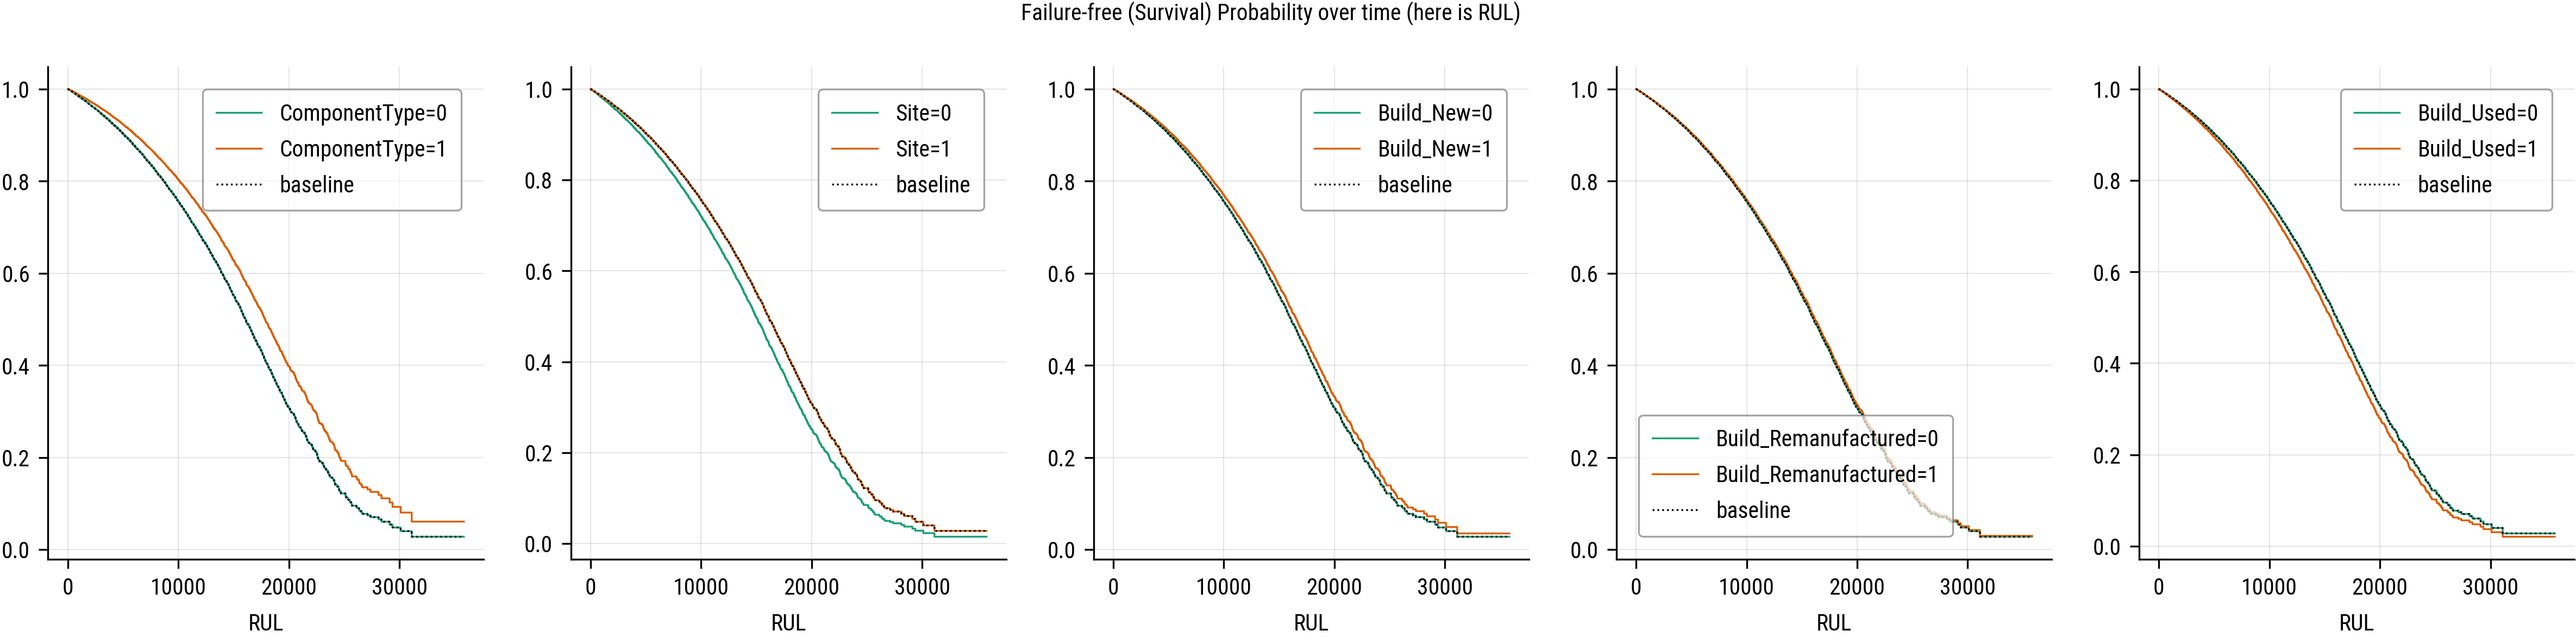

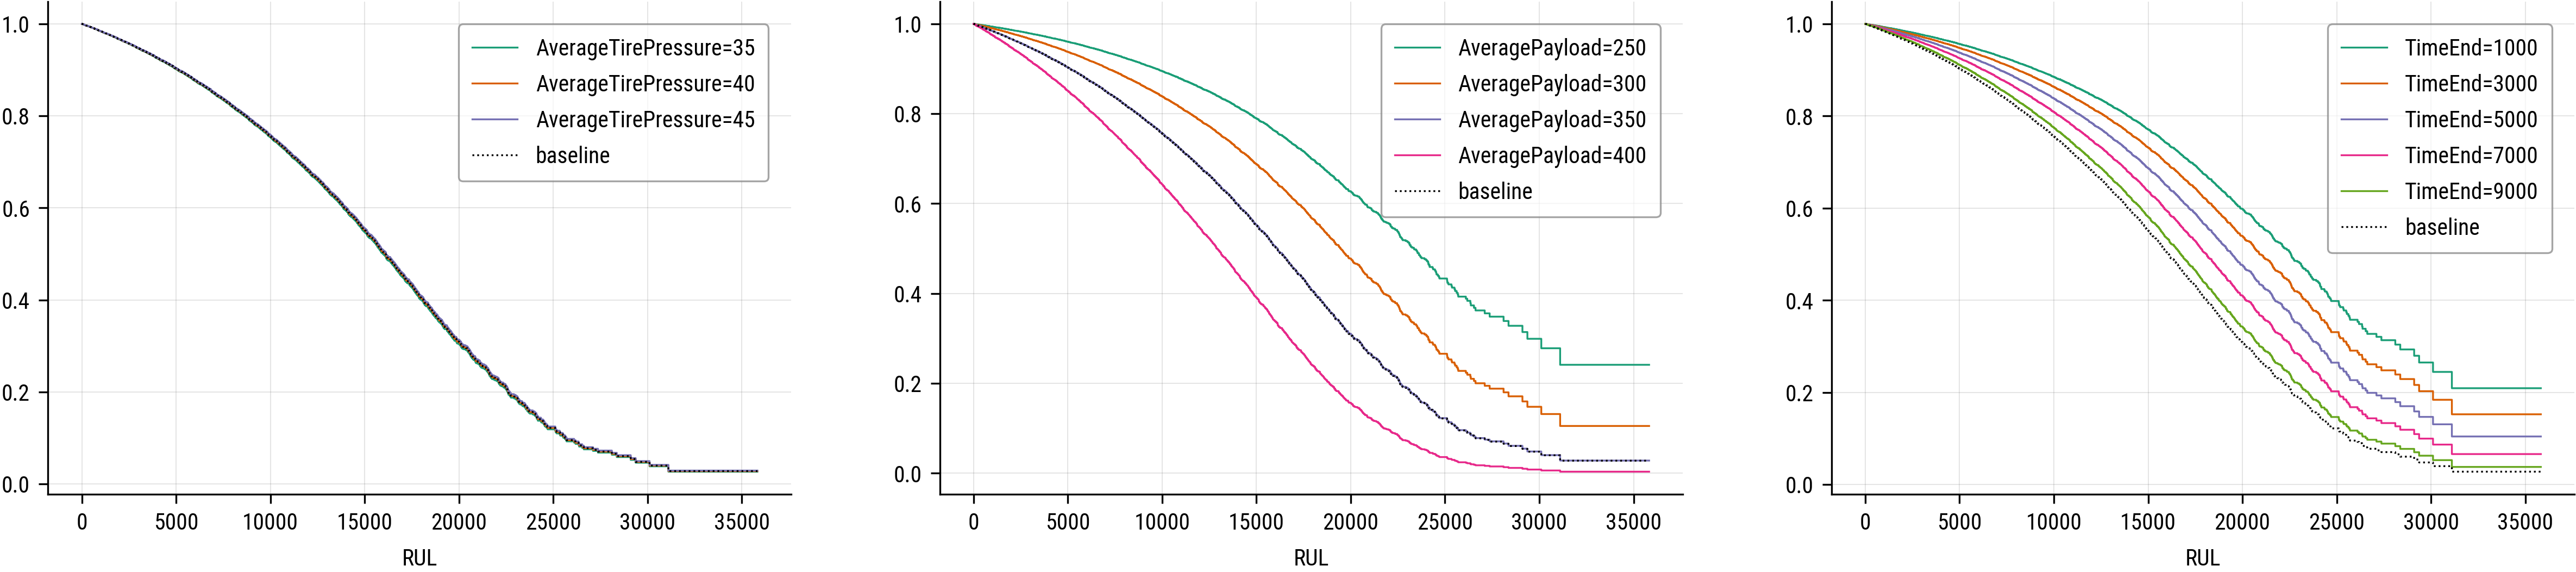

In [16]:
variables = x_binary+dummies
fig, ax = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 4))
for i in range(len(variables)):
    cph.plot_partial_effects_on_outcome(variables[i], values=[0,1], ax=ax[i], xlabel='RUL')
plt.suptitle('Failure-free (Survival) Probability over time (here is RUL)')
plt.show()

values = [np.arange(35, 50, 5),np.arange(250, 450, 50),np.arange(1000, 10000, 2000)]
fig, ax = plt.subplots(nrows=1, ncols=len(x_numerical), figsize=(20, 4))
for i in range(len(x_numerical)):
    cph.plot_partial_effects_on_outcome(x_numerical[i], values=values[i], ax=ax[i], xlabel='RUL')
plt.show()